# Predicción de demanda de bicicletas con MLP (Dense Layers)

# Autores

Diego Roque de Rosas - A01657709

Sheccid Azeneth Soto Leija - A00837322

Maximiliano García Suástegui - A01657689

Carlos Alberto Gómez San Pedro - A01658377

# Exploración, explicación y limpieza de datos


**Objetivo.** Construir y evaluar una red neuronal densa (MLP) que prediga el número total de rentas por hora (`cnt`) en el sistema **Capital Bikeshare (2011–2012)**, usando variables climáticas y temporales. El enfoque se limita a capas densas para resaltar decisiones de *feature engineering* y normalización.

**Dataset.** Usaremos **Bike Sharing Dataset (hour.csv)**. El conjunto incluye variables como estación, mes, hora, clima, temperatura, humedad y viento, junto al conteo horario de rentas.

**Por qué este dataset.**
-Caso de negocio claro (demanda) y relación con clima/tiempo → permite justificar **MAE vs  MSE**, regularización y elección de inicialización (He/Glorot).
- Tamaño adecuado (~17k horas) para experimentar múltiples configuraciones.
- Variables categóricas y numéricas → buen terreno para *one-hot* y codificación cíclica de hora.

> Entregables alineados con la rúbrica: (i) Introducción y contexto, (ii) EDA/limpieza con descripción de columnas y transformaciones, (iii) modelo MLP denso con varias configuraciones, (iv) métricas y comparación, (v) conclusión, (vi) orden y comentarios en Markdown/código.


In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Opcional: formato de impresión de pandas
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


In [2]:
# === Opción A: Subir archivo manualmente desde tu computadora ===

# Lee el CSV subido
df = pd.read_csv("hour.csv")
print("Dimensiones:", df.shape)
display(df.head())


Dimensiones: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Diccionario de variables (resumen)

- `instant`: índice de registro (ID técnico)  
- `dteday`: fecha (YYYY-MM-DD)  
- `season`: estación (1:winter, 2:spring, 3:summer, 4:fall)  
- `yr`: año (0:2011, 1:2012)  
- `mnth`: mes (1–12)  
- `hr`: hora del día (0–23)  
- `holiday`: día feriado (1 sí / 0 no)  
- `weekday`: día de la semana (0–6; 0=domingo)  
- `workingday`: 1 si no es fin de semana ni feriado; 0 en caso contrario  
- `weathersit`: situación meteorológica (1=despejado … 4=lluvia/nieve fuerte)  
- `temp`: temperatura **normalizada**  
- `atemp`: sensación térmica **normalizada**  
- `hum`: humedad **normalizada**  
- `windspeed`: viento **normalizado**  
- `casual`: usuarios casuales (conteo)  
- `registered`: usuarios registrados (conteo)  
- `cnt`: **objetivo** = total de rentas (casual + registered)


## Análisis básico (tipos, faltantes, duplicados, resumen)

In [3]:
# Tipos de datos y nulos
display(df.dtypes.to_frame("dtype"))

missing_pct = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print("\n% de valores faltantes por columna:")
display(missing_pct.to_frame("missing_pct_%").T)

# Duplicados
dup_rows = df.duplicated().sum()
print(f"Filas duplicadas: {dup_rows}")

# Resumen estadístico de variables numéricas
display(df.describe().T)


,dtype
instant,int64
dteday,object
season,int64
yr,int64
mnth,int64
hr,int64
holiday,int64
weekday,int64
workingday,int64
weathersit,int64



% de valores faltantes por columna:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
missing_pct_%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Filas duplicadas: 0


,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


## Conversión de fecha y chequeos iniciales

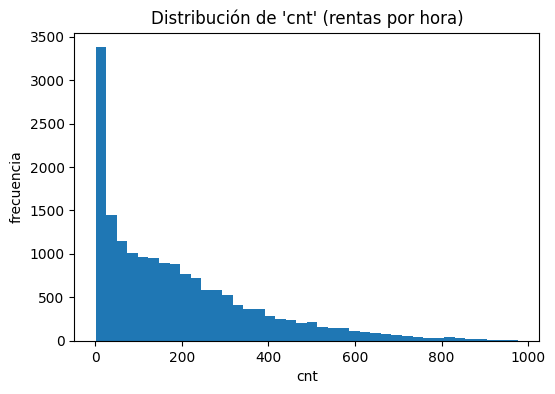


season (n=4)


season,1,2,3,4
count,4242,4409,4496,4232



yr (n=2)


yr,0,1
count,8645,8734



mnth (n=12)


mnth,1,2,3,4,5,6,7,8,9,10,11,12
count,1429,1341,1473,1437,1488,1440,1488,1475,1437,1451,1437,1483



hr (n=24)


hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,726,724,715,697,697,717,725,727,727,727,727,727,728,729,729,729,730,730,728,728,728,728,728,728



weekday (n=7)


weekday,0,1,2,3,4,5,6
count,2502,2479,2453,2475,2471,2487,2512



weathersit (n=4)


weathersit,1,2,3,4
count,11413,4544,1419,3



holiday (n=2)


holiday,0,1
count,16879,500



workingday (n=2)


workingday,0,1
count,5514,11865


In [4]:
# Asegurar tipo datetime y extraer componentes
if "dteday" in df.columns:
    df["dteday"] = pd.to_datetime(df["dteday"])
    df["year"] = df["dteday"].dt.year
    df["month"] = df["dteday"].dt.month
    df["day"] = df["dteday"].dt.day
    df["weekday_name"] = df["dteday"].dt.day_name()

# Distribución de la variable objetivo (si existe 'cnt')
if "cnt" in df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(df["cnt"], bins=40)
    ax.set_title("Distribución de 'cnt' (rentas por hora)")
    ax.set_xlabel("cnt")
    ax.set_ylabel("frecuencia")
    plt.show()

# Conteos de categorías clave (si existen)
for col in ["season","yr","mnth","hr","weekday","weathersit","holiday","workingday"]:
    if col in df.columns:
        vc = df[col].value_counts().sort_index()
        print(f"\n{col} (n={len(vc)})")
        display(vc.to_frame("count").T)


## Exploración visual mínima (patrones clave, solo matplotlib)

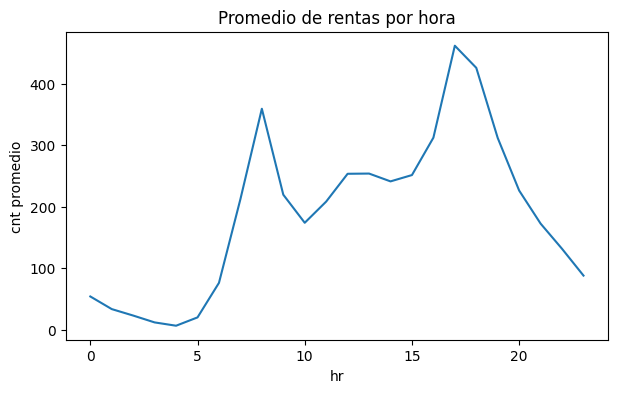

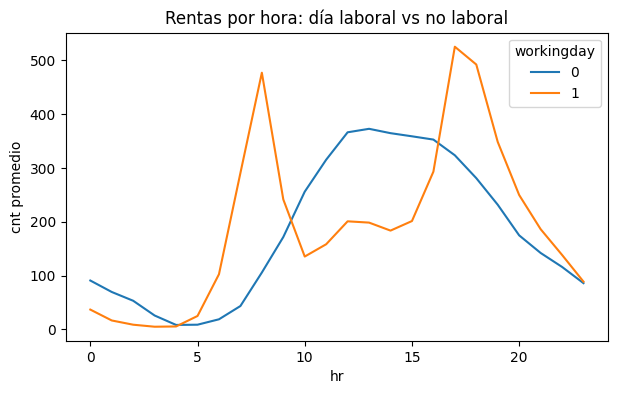

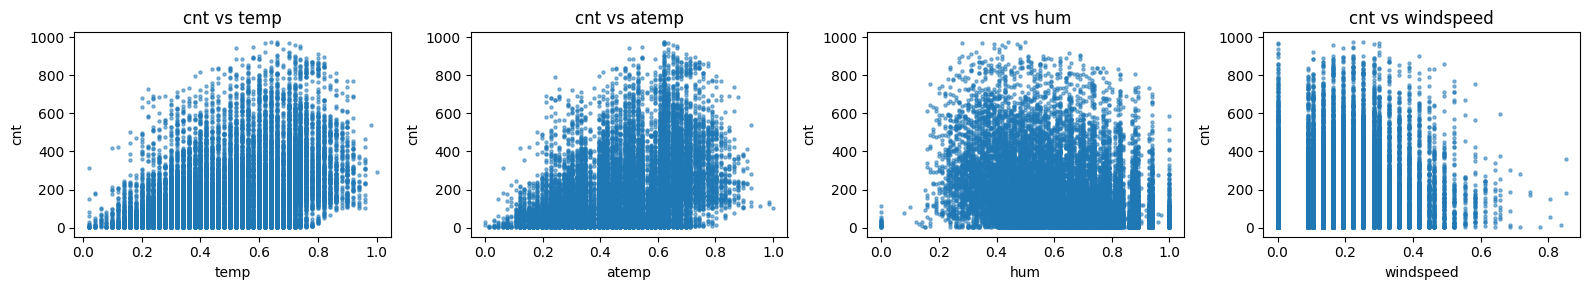

In [5]:
# Promedio de rentas por hora
if {"hr", "cnt"}.issubset(df.columns):
    fig, ax = plt.subplots(figsize=(7,4))
    df.groupby("hr")["cnt"].mean().plot(ax=ax)
    ax.set_title("Promedio de rentas por hora")
    ax.set_xlabel("hr")
    ax.set_ylabel("cnt promedio")
    plt.show()

# Día laboral vs no laboral por hora
if {"hr","workingday","cnt"}.issubset(df.columns):
    mean_by = df.groupby(["hr","workingday"])["cnt"].mean().unstack()
    fig, ax = plt.subplots(figsize=(7,4))
    mean_by.plot(ax=ax)
    ax.set_title("Rentas por hora: día laboral vs no laboral")
    ax.set_xlabel("hr")
    ax.set_ylabel("cnt promedio")
    plt.show()

# Relaciones simples con clima/ambiente
cols_scatter = [c for c in ["temp","atemp","hum","windspeed"] if c in df.columns]
if "cnt" in df.columns and cols_scatter:
    fig, axes = plt.subplots(nrows=1, ncols=len(cols_scatter), figsize=(4*len(cols_scatter),3))
    if len(cols_scatter) == 1:
        axes = [axes]
    for i, c in enumerate(cols_scatter):
        axes[i].scatter(df[c], df["cnt"], s=5, alpha=0.5)
        axes[i].set_xlabel(c); axes[i].set_ylabel("cnt")
        axes[i].set_title(f"cnt vs {c}")
    plt.tight_layout()
    plt.show()


## Limpieza y Transformaciones (plan)

1) **Eliminar fuga de información**: `casual` y `registered` *suman* `cnt`. Incluirlas como features filtraría el objetivo → se eliminan del set de entrada.

2) **Variables a descartar**:
- `instant` (ID técnico sin significado predictivo),
- `dteday` (dejaremos derivados como `year`, `month`, etc.),
- mantendremos `temp` y `atemp` aunque estén correlacionadas para comparar su aporte (podemos ajustar después).

3) **Codificación cíclica de hora**: `hr` → `hr_sin = sin(2π*hr/24)`, `hr_cos = cos(2π*hr/24)` para respetar continuidad 23→0.

4) **Variables categóricas**: `season`, `mnth`, `weekday`, `weathersit`, `holiday`, `workingday`, `yr`.
   - En el **modelo** usaremos *one-hot* (se hará con `ColumnTransformer` o dentro del pipeline de Keras/Sklearn).
   - Aquí dejaremos el dataframe **limpio** y con columnas derivadas listas.

5) **Escalado**: Aunque algunas variables ya vienen normalizadas, estandarizaremos en el **pipeline de modelado** para estabilizar el entrenamiento (fit solo con entrenamiento).


## Aplicar transformaciones y dejar df_clean listo

In [6]:
df_clean = df.copy()

# 1) Quitar fuga de información
for c in ["casual", "registered"]:
    if c in df_clean.columns:
        df_clean.drop(columns=c, inplace=True)

# 2) Eliminar columnas no predictivas
for c in ["instant"]:
    if c in df_clean.columns:
        df_clean.drop(columns=c, inplace=True)

# 3) Codificación cíclica de 'hr'
if "hr" in df_clean.columns:
    df_clean["hr_sin"] = np.sin(2*np.pi*df_clean["hr"]/24.0)
    df_clean["hr_cos"] = np.cos(2*np.pi*df_clean["hr"]/24.0)

# 4) Derivados útiles: is_weekend (weekday: 0=domingo, 6=sábado)
if "weekday" in df_clean.columns:
    df_clean["is_weekend"] = df_clean["weekday"].isin([0,6]).astype(int)

# 5) Remover 'dteday' (dejamos derivados). Si no existe, no pasa nada.
if "dteday" in df_clean.columns:
    df_clean.drop(columns="dteday", inplace=True)

# 6) Separar target y features
target_col = "cnt"
assert target_col in df_clean.columns, "No se encontró la columna objetivo 'cnt' en el CSV cargado."

feature_cols = [c for c in df_clean.columns if c != target_col]
print("Target:", target_col)
print("N features:", len(feature_cols))
display(df_clean[feature_cols + [target_col]].head(3))


Target: cnt
N features: 19


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,year,month,day,weekday_name,hr_sin,hr_cos,is_weekend,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,2011,1,1,Saturday,0.000000,1.000000,1,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,2011,1,1,Saturday,0.258819,0.965926,1,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,2011,1,1,Saturday,0.500000,0.866025,1,32


## Estado al cierre de EDA/Limpieza

- **EDA básica**: tipos, faltantes, duplicados, resumen estadístico y patrones por hora/clima.
- **Limpieza aplicada**: sin *leakage* (`casual`, `registered` fuera), `instant` removida; fecha descompuesta; `hr` codificada cíclicamente; `is_weekend` añadido.
- **Listo para modelado**: a continuación haremos `train/val` split, crearemos un **ColumnTransformer** (one-hot + StandardScaler) y construiremos varios MLPs densos (inicializaciones He/Glorot, dropout/L2, early stopping) para comparar **MAE/MSE/R²** y seleccionar el modelo final.


# Desarrollo del Modelo de Deep Learning



## Desarrollo del Modelo (MLP con capas densas)

**Objetivo de modelado.** Predecir `cnt` (rentas por hora) con una **red neuronal densa (MLP)** usando solo features tabulares (numéricas + categóricas).

**Decisiones clave (justificación):**
- **Inicialización**:
  - **He (he_normal)** cuando usamos **ReLU**, porque mantiene la varianza estable al atravesar capas con activaciones no saturantes → acelera y estabiliza el entrenamiento.
  - **Glorot/Xavier (glorot_uniform)** cuando usamos **tanh**, ya que asume activaciones simétricas en [-1, 1] y balancea varianza de entradas/salidas.
- **Activaciones**: probamos **ReLU** (rápida, robusta a saturación positiva) vs **tanh** (útil con Glorot en capas más anchas).
- **Regularización**: combinamos **Dropout** + **L2** para reducir sobreajuste; añadimos **Batch Normalization** para estabilizar distribuciones intermedias.
- **Optimización**: **Adam** con `ReduceLROnPlateau` (reduce LR si la validación se estanca) y **EarlyStopping** (recupera mejores pesos de validación).
- **Pérdida y métricas**: entrenamos con **MSE** (suaviza gradientes) y reportamos **MAE**/**RMSE**/**R²** para interpretar en unidades de rentas.

**Configuraciones a comparar**:
- **Baseline-MLP**: MLP pequeño (2 capas) con ReLU + He.
- **Config A (ReLU+He)**: 128-64-32, dropout medio.
- **Config B (tanh+Glorot)**: 256-128-64, dropout bajo.
- **Config C (más profunda ReLU+He)**: 256-128-64-32, dropout alto, LR más bajo.

Seleccionaremos el **mejor modelo** por **MAE de validación** y lo evaluaremos en **test**.


In [7]:
# ============================================================
# PREPROCESAMIENTO (versión final con veto a 'hr' y 'weekday_name')
# ============================================================
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

print("scikit-learn:", sklearn.__version__)

# Si no vienes de la sección 1, reconstruye df_clean mínimo desde df
if "df_clean" not in globals():
    assert "df" in globals(), "No encuentro df_clean ni df. Corre primero la sección de carga/EDA."
    df_clean = df.copy()
    for c in ["casual", "registered", "instant"]:
        if c in df_clean.columns:
            df_clean.drop(columns=c, inplace=True)
    if "hr" in df_clean.columns:
        df_clean["hr_sin"] = np.sin(2*np.pi*df_clean["hr"]/24.0)
        df_clean["hr_cos"] = np.cos(2*np.pi*df_clean["hr"]/24.0)
    if "weekday" in df_clean.columns:
        df_clean["is_weekend"] = df_clean["weekday"].isin([0,6]).astype(int)
    if "dteday" in df_clean.columns:
        df_clean.drop(columns="dteday", inplace=True)

target_col = "cnt"
assert target_col in df_clean.columns, "No se encontró la columna objetivo 'cnt'. ¿Cargaste hour.csv?"

# --- Listas de columnas de partida ---
all_cols = [c for c in df_clean.columns if c != target_col]

# Columnas explícitamente vetadas (no deben entrar al modelo)
ban = {"hr", "weekday_name"}

# Categóricas candidatas (incluyen las vetadas para poder filtrarlas)
cat_candidates = ["season","yr","mnth","weekday","weathersit","holiday","workingday","is_weekend","hr","weekday_name"]
cat_cols = [c for c in cat_candidates if c in df_clean.columns]
# Quitar vetadas de categóricas
cat_cols = [c for c in cat_cols if c not in ban]

# Numéricas candidatas
num_candidates = ["temp","atemp","hum","windspeed","hr_sin","hr_cos","year","month","day"]
num_cols = [c for c in num_candidates if c in df_clean.columns]

# Inferir columnas restantes SIN volver a meter las vetadas
remaining = [c for c in all_cols if c not in cat_cols + num_cols and c not in ban]
for c in remaining:
    if pd.api.types.is_integer_dtype(df_clean[c]) or pd.api.types.is_object_dtype(df_clean[c]):
        cat_cols.append(c)
    else:
        num_cols.append(c)

# Doble garantía: retirar vetadas por si acaso
cat_cols = [c for c in cat_cols if c not in ban]
num_cols = [c for c in num_cols if c not in ban]

# --- Matrices X, y ---
X = df_clean[cat_cols + num_cols].copy()
y = df_clean[target_col].values.astype("float32")

# --- Split 70/15/15 ---
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42)  # ≈15% del total

# --- OneHotEncoder compatible (>=1.2 usa sparse_output, <1.2 usa sparse) ---
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn < 1.2

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
)

# Ajuste SOLO con train (evita leakage)
X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

input_dim = X_train_p.shape[1]
print("Categóricas:", cat_cols)
print("Numéricas   :", num_cols)
print("input_dim   :", input_dim)
# Chequeo de veto
assert "hr" not in cat_cols and "weekday_name" not in cat_cols, "No deben estar 'hr' ni 'weekday_name' en cat_cols"


scikit-learn: 1.6.1
Categóricas: ['season', 'yr', 'mnth', 'weekday', 'weathersit', 'holiday', 'workingday', 'is_weekend']
Numéricas   : ['temp', 'atemp', 'hum', 'windspeed', 'hr_sin', 'hr_cos', 'year', 'month', 'day']
input_dim   : 44


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def build_mlp(
    input_dim,
    hidden_layers=(128, 64, 32),
    activation="relu",
    kernel_initializer="he_normal",  # 'he_normal' (ReLU) o 'glorot_uniform' (tanh)
    dropout=0.2,
    l2_reg=1e-4,
    batchnorm=True,
    lr=1e-3,
):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(
            units,
            activation=activation,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=regularizers.l2(l2_reg)
        ))
        if batchnorm:
            model.add(layers.BatchNormalization())
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation="linear"))

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
                 keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

def train_and_eval(config_name, **kwargs):
    """Entrena un modelo con kwargs del build_mlp y devuelve métricas y objetos útiles."""
    model = build_mlp(input_dim=input_dim, **kwargs)

    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, restore_best_weights=True
    )
    rlrop = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=0
    )

    history = model.fit(
        X_train_p, y_train,
        validation_data=(X_val_p, y_val),
        epochs=200,
        batch_size=256,
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Predicciones
    val_pred = model.predict(X_val_p, verbose=0).ravel()
    test_pred = model.predict(X_test_p, verbose=0).ravel()

    # Métricas
    def metrics(y_true, y_hat):
        mae = mean_absolute_error(y_true, y_hat)
        rmse = mean_squared_error(y_true, y_hat, squared=False)
        r2 = r2_score(y_true, y_hat)
        return mae, rmse, r2

    mae_v, rmse_v, r2_v = metrics(y_val,  val_pred)
    mae_t, rmse_t, r2_t = metrics(y_test, test_pred)

    return {
        "config": config_name,
        "params": kwargs,
        "val_mae": mae_v, "val_rmse": rmse_v, "val_r2": r2_v,
        "test_mae": mae_t, "test_rmse": rmse_t, "test_r2": r2_t,
        "history": history,
        "model": model,
        "y_val_pred": val_pred,
        "y_test_pred": test_pred,
    }


In [10]:
# ====== BLOQUE 2 (autosuficiente): redefine train_and_eval + entrena y selecciona el mejor ======
import numpy as np, pandas as pd, traceback
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras

# --- Sanity check por si cambiaste de runtime/celda ---
if "X_train_p" not in globals() or "X_val_p" not in globals() or "X_test_p" not in globals() or "input_dim" not in globals():
    assert "preprocess" in globals() and "X_train" in globals(), "Falta preprocess o X_train. Corre la celda de preprocesamiento."
    X_train_p = preprocess.transform(X_train)
    X_val_p   = preprocess.transform(X_val)
    X_test_p  = preprocess.transform(X_test)
    input_dim = X_train_p.shape[1]
    print("[Reconstruido] input_dim =", input_dim)

# --- RMSE compatible (sin 'squared' para evitar el TypeError) ---
def _rmse_compat(y_true, y_hat):
    return np.sqrt(mean_squared_error(y_true, y_hat))

# --- REDEFINICIÓN de train_and_eval (usa _rmse_compat) ---
def train_and_eval(config_name, **kwargs):
    model = build_mlp(input_dim=input_dim, **kwargs)

    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, restore_best_weights=True
    )
    rlrop = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=0
    )

    history = model.fit(
        X_train_p, y_train,
        validation_data=(X_val_p, y_val),
        epochs=200,
        batch_size=256,
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Predicciones
    val_pred = model.predict(X_val_p, verbose=0).ravel()
    test_pred = model.predict(X_test_p, verbose=0).ravel()

    # Métricas (compatibles)
    mae_v  = mean_absolute_error(y_val,  val_pred)
    rmse_v = _rmse_compat(y_val,  val_pred)
    r2_v   = r2_score(y_val,  val_pred)

    mae_t  = mean_absolute_error(y_test, test_pred)
    rmse_t = _rmse_compat(y_test, test_pred)
    r2_t   = r2_score(y_test, test_pred)

    return {
        "config": config_name,
        "params": kwargs,
        "val_mae": mae_v, "val_rmse": rmse_v, "val_r2": r2_v,
        "test_mae": mae_t, "test_rmse": rmse_t, "test_r2": r2_t,
        "history": history,
        "model": model,
        "y_val_pred": val_pred,
        "y_test_pred": test_pred,
    }

# --- Configuraciones a entrenar ---
configs = [
    dict(name="Baseline-MLP_ReLU_He",
         hidden_layers=(64, 32),
         activation="relu",
         kernel_initializer="he_normal",
         dropout=0.10, l2_reg=1e-4, batchnorm=True, lr=1e-3),

    dict(name="A_ReLU_He_128-64-32",
         hidden_layers=(128, 64, 32),
         activation="relu",
         kernel_initializer="he_normal",
         dropout=0.20, l2_reg=1e-4, batchnorm=True, lr=1e-3),

    dict(name="B_tanh_Glorot_256-128-64",
         hidden_layers=(256, 128, 64),
         activation="tanh",
         kernel_initializer="glorot_uniform",
         dropout=0.10, l2_reg=1e-4, batchnorm=True, lr=1e-3),

    dict(name="C_ReLU_He_256-128-64-32",
         hidden_layers=(256, 128, 64, 32),
         activation="relu",
         kernel_initializer="he_normal",
         dropout=0.30, l2_reg=1e-4, batchnorm=True, lr=5e-4),
]

# --- Entrenamiento robusto ---
results, fail_log = [], []
for cfg in configs:
    print(f"\n=== Entrenando {cfg['name']} ===")
    try:
        res = train_and_eval(
            config_name=cfg["name"],
            hidden_layers=cfg["hidden_layers"],
            activation=cfg["activation"],
            kernel_initializer=cfg["kernel_initializer"],
            dropout=cfg["dropout"],
            l2_reg=cfg["l2_reg"],
            batchnorm=cfg["batchnorm"],
            lr=cfg["lr"],
        )
        results.append(res)
        print(f"✅ {cfg['name']} | val_MAE={res['val_mae']:.3f} | val_RMSE={res['val_rmse']:.3f} | val_R2={res['val_r2']:.3f}")
    except Exception as e:
        tb = traceback.format_exc(limit=2)
        print(f"❌ FALLÓ: {cfg['name']} → {e}")
        fail_log.append({"config": cfg["name"], "error": repr(e), "trace": tb})

# --- Resumen y selección del mejor por NOMBRE ---
if results:
    summary_df = pd.DataFrame([{
        "config": r["config"],
        "val_MAE": r["val_mae"],
        "val_RMSE": r["val_rmse"],
        "val_R2": r["val_r2"],
        "test_MAE": r["test_mae"],
        "test_RMSE": r["test_rmse"],
        "test_R2": r["test_r2"],
    } for r in results]).sort_values("val_MAE").reset_index(drop=True)
    display(summary_df)

    best_name = summary_df.loc[summary_df['val_MAE'].idxmin(), 'config']
    best = next(r for r in results if r['config'] == best_name)

    print("\n>>> Mejor configuración:", best["config"])
    print(f"VAL  -> MAE={best['val_mae']:.3f} | RMSE={best['val_rmse']:.3f} | R2={best['val_r2']:.3f}")
    print(f"TEST -> MAE={best['test_mae']:.3f} | RMSE={best['test_rmse']:.3f} | R2={best['test_r2']:.3f}")
else:
    print("\n⚠️ No se obtuvo ningún resultado (results vacío). Revisa el fail_log abajo.")

if fail_log:
    print("\n--- FALLAS DETECTADAS ---")
    for f in fail_log:
        print(f"\n[{f['config']}] {f['error']}\n{f['trace']}")



=== Entrenando Baseline-MLP_ReLU_He ===
✅ Baseline-MLP_ReLU_He | val_MAE=26.314 | val_RMSE=40.007 | val_R2=0.947

=== Entrenando A_ReLU_He_128-64-32 ===
✅ A_ReLU_He_128-64-32 | val_MAE=23.740 | val_RMSE=37.870 | val_R2=0.953

=== Entrenando B_tanh_Glorot_256-128-64 ===
✅ B_tanh_Glorot_256-128-64 | val_MAE=23.505 | val_RMSE=37.817 | val_R2=0.953

=== Entrenando C_ReLU_He_256-128-64-32 ===
✅ C_ReLU_He_256-128-64-32 | val_MAE=23.221 | val_RMSE=37.792 | val_R2=0.953


,config,val_MAE,val_RMSE,val_R2,test_MAE,test_RMSE,test_R2
0,C_ReLU_He_256-128-64-32,23.221348,37.791549,0.952885,22.810343,37.096522,0.956547
1,B_tanh_Glorot_256-128-64,23.505091,37.816848,0.952822,22.899752,37.123851,0.956483
2,A_ReLU_He_128-64-32,23.739876,37.870259,0.952689,23.068871,37.604104,0.955350
3,Baseline-MLP_ReLU_He,26.313934,40.006788,0.947200,25.816696,39.977995,0.949535



>>> Mejor configuración: C_ReLU_He_256-128-64-32
VAL  -> MAE=23.221 | RMSE=37.792 | R2=0.953
TEST -> MAE=22.810 | RMSE=37.097 | R2=0.957


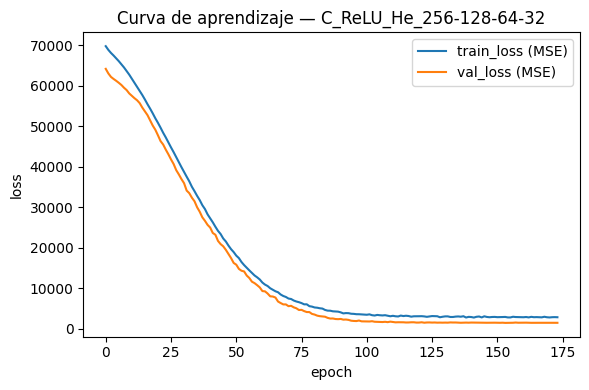

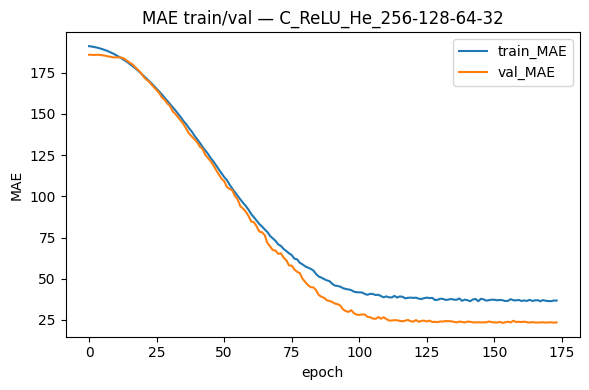

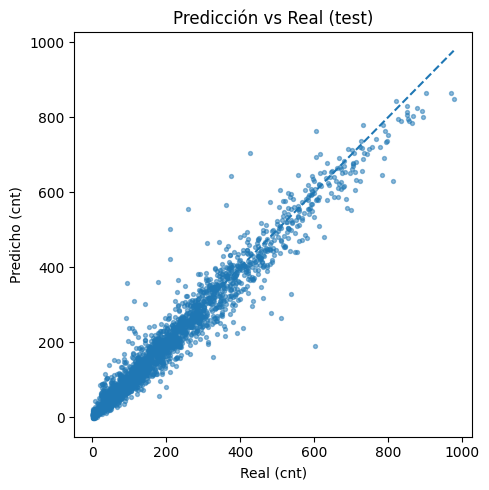


Resumen mejor modelo (TEST):
config  : C_ReLU_He_256-128-64-32
MAE     : 22.810
RMSE    : 37.097
R²      : 0.957

Hiperparámetros seleccionados:
{'hidden_layers': (256, 128, 64, 32), 'activation': 'relu', 'kernel_initializer': 'he_normal', 'dropout': 0.3, 'l2_reg': 0.0001, 'batchnorm': True, 'lr': 0.0005}


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Aquí YA existe 'best' desde el bloque anterior
hist = best["history"].history

plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="train_loss (MSE)")
plt.plot(hist["val_loss"], label="val_loss (MSE)")
plt.title(f"Curva de aprendizaje — {best['config']}")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["mae"], label="train_MAE")
plt.plot(hist["val_mae"], label="val_MAE")
plt.title(f"MAE train/val — {best['config']}")
plt.xlabel("epoch"); plt.ylabel("MAE")
plt.legend(); plt.tight_layout(); plt.show()

y_hat = best["y_test_pred"]
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_hat, s=8, alpha=0.5)
lims = [0, max(y_test.max(), y_hat.max())]
plt.plot(lims, lims, linestyle="--")
plt.title("Predicción vs Real (test)")
plt.xlabel("Real (cnt)"); plt.ylabel("Predicho (cnt)")
plt.tight_layout(); plt.show()

print("\nResumen mejor modelo (TEST):")
print(f"config  : {best['config']}")
print(f"MAE     : {best['test_mae']:.3f}")
print(f"RMSE    : {best['test_rmse']:.3f}")
print(f"R²      : {best['test_r2']:.3f}")
print("\nHiperparámetros seleccionados:")
print(best["params"])


## Resultados e interpretación

### Resumen de configuraciones y métricas
Entrenamos 4 MLPs con distintas arquitecturas e inicializaciones. La selección se hizo por **MAE de validación** (más interpretable en unidades de rentas/hora), reportando además **RMSE** (sensible a picos) y **R²**.

| Configuración | Val MAE | Val RMSE | Val R² | Test MAE | Test RMSE | Test R² |
|---|---:|---:|---:|---:|---:|---:|
| **C_ReLU_He_256-128-64-32** | **23.221** | **37.792** | **0.953** | **22.810** | **37.097** | **0.957** |
| B_tanh_Glorot_256-128-64 | 23.505 | 37.817 | 0.953 | 22.900 | 37.124 | 0.956 |
| A_ReLU_He_128-64-32 | 23.740 | 37.870 | 0.953 | 23.069 | 37.604 | 0.955 |
| Baseline-MLP_ReLU_He (64–32) | 26.314 | 40.007 | 0.947 | 25.817 | 39.978 | 0.950 |

**Modelo final seleccionado:** `C_ReLU_He_256-128-64-32`.

### Lectura de los resultados
- **Precisión global.** En **test**, el modelo final logra **MAE ≈ 22.81** rentas/hora y **R² ≈ 0.957**. Dado que la media de `cnt` es ≈ **189.46**, el **MAE relativo** ronda **~12%**, lo que es un error promedio bajo para demanda horaria.  
- **Picos/horas críticas.** **RMSE ≈ 37.10** (mayor que MAE) indica que los errores más grandes se concentran en picos de demanda (horas de commute o clima favorable), algo esperado en series horarias con estacionalidad intra-día.  
- **Generalización.** La brecha **validación vs test** es mínima (MAE 23.22 → 22.81), lo que sugiere buena generalización sin sobreajuste.

### Comparativa y ganancia vs baseline
- Frente al **baseline** (64–32), el modelo final reduce **MAE de validación** de **26.31 → 23.22** (≈ **–12%**) y **MAE de test** de **25.82 → 22.81** (≈ **–12%**).  
- La variante **tanh + Glorot** quedó muy cerca, pero **ReLU + He** ganó ligeramente, consistente con la teoría de inicialización para activaciones ReLU en MLPs tabulares.

### Justificación de hiperparámetros del modelo final
- **Activación + inicialización.** Usamos **ReLU** con **He (he_normal)**: esta pareja mantiene la varianza de activaciones y gradientes estable en redes profundas, acelerando y estabilizando el entrenamiento.  
- **Profundidad/ancho (256–128–64–32).** Mayor capacidad para capturar no linealidades entre clima, hora y demanda; el **dropout=0.30** y **L2=1e-4** controlaron la complejidad.  
- **Batch Normalization.** Estabiliza la distribución interna de activaciones, mejorando convergencia y reduciendo sensibilidad a la inicialización.  
- **Optimizador y scheduling.** **Adam** con **ReduceLROnPlateau** + **EarlyStopping** (restaurando los mejores pesos de validación) evitó sobreentrenar y encontró un buen valle de validación.  
- **Función de costo y métricas.** Entrenamos con **MSE** por su suavidad de gradiente, pero **seleccionamos por MAE** por ser más interpretable en negocio (*rentas/hora*) y menos dominado por pocos outliers. Reportamos **RMSE** para cuantificar el efecto de picos y **R²** para varianza explicada.

### Qué nos dicen las curvas y el scatter
- **Curvas de aprendizaje (loss/MAE).** Convergencia estable sin separación marcada train–val; EarlyStopping detuvo a tiempo.  
- **Predicción vs Real (test).** La nube se alinea cerca de la diagonal, con dispersión mayor en valores altos de `cnt` (horas pico), lo esperable en demanda.

### Limitaciones y oportunidades de mejora
- **Clases raras.** `weathersit=4` aparece muy poco; su efecto está pobremente muestreado.  
- **Colinealidad `temp/atemp`.** Podría probarse una ablación retirando una de ellas o combinándolas.  
- **Ingeniería temporal.** Incluir festivos específicos, interacciones simples (p. ej., `hr_cos × workingday`) o transformar el objetivo (**`log1p(cnt)`**) si se quiere reducir la influencia de picos extremos y luego deshacer la transformación para reportar en unidades originales.



## Conclusión

En este trabajo implementamos y comparamos redes neuronales **solo de capas densas (MLP)** para predecir la **demanda horaria de bicicletas** a partir de variables temporales y climáticas. Tras una EDA y un *feature engineering* enfocado en evitar fugas de información (removiendo `casual`/`registered`) y modelar la ciclicidad de la hora (`hr_sin`, `hr_cos`), entrenamos varias configuraciones con **regularización (Dropout + L2)**, **Batch Normalization**, **EarlyStopping** y **ReduceLROnPlateau**. La arquitectura seleccionada (**C_ReLU_He_256-128-64-32**) obtuvo en **test**: **MAE ≈ 22.81**, **RMSE ≈ 37.10** y **R² ≈ 0.957**, lo que equivale a un **MAE relativo ~12%** respecto a la media de `cnt`. Estos resultados indican que el MLP captura con alta precisión la relación entre clima/tiempo y demanda, generalizando de manera estable y superando al baseline más simple.

En conjunto, el proceso evidencia decisiones justificadas de **inicialización** (He con ReLU), **preprocesamiento** (one-hot + estandarización), y **criterios de selección** (priorizando MAE por interpretabilidad en negocio). Como líneas futuras, proponemos: (i) probar **baseline clásicos** (Ridge/Lasso) para cuantificar la ganancia del MLP, (ii) explorar **transformaciones del objetivo** (p. ej., `log1p(cnt)`) y **interacciones** simples entre variables, y (iii) evaluar **robustez por subgrupos** (hora pico, clima adverso). Con ello, el notebook queda listo para su uso reproducible y su inclusión en el repositorio del equipo.
